In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"epl-spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:32, 11.57it/s]


game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0  14562.0        1.0          0           1.0  00:00:01.344     58.0   
1  14562.0        1.0          1           1.5  00:00:02.117     58.0   
2  14562.0        1.0          2           2.0  00:00:02.117     58.0   
3  14562.0        1.0          3           2.0  00:00:02.969     58.0   
4  14562.0        1.0          4           3.0  00:00:04.338     58.0   

   player_id          x          y         dx         dy  type_id  \
0     9923.0  52.058824  34.430380 -10.588235  -0.000000        0   
1     9917.0  41.470588  34.430380  -0.000000  -0.000000       23   
2     9917.0  41.470588  34.430380  -0.000000  -0.000000       21   
3     9917.0  41.470588  34.430380 -15.882353 -14.632911        0   
4     9924.0  25.588235  19.797468  -0.000000  -0.000000       23   

   bodypart_id type_name  
0            0      pass  
1            0  receival  
2            0   dribble  
3            0      pass  
4            0  receival

In [ ]:
from scipy.spatial import Delaunay
import networkx as nx

def color_clusters(clusters,colors):
    tri = Delaunay(clusters)
    edges = set()
    for s in tri.simplices:
        [a,b,c] = s
        es = set([frozenset([a,b]),frozenset([b,c]),frozenset([c,a])])
        edges = edges | es
    G = nx.Graph()
    for e in edges:
        [i,j] = list(e)
        G.add_edge(i, j)
    
    if len(G.nodes) > 0:
        r_ = max([G.degree(node) for node in G.nodes])
    else:
        r_ = 0
    if r_ > len(colors)-1:
        colorassign = nx.algorithms.coloring.greedy_color(G)
    else:
        colorassign = nx.algorithms.coloring.equitable_color(G,len(colors))
    colorvector = [0] * len(clusters)
    for k,v in colorassign.items():
        colorvector[k] = int(v)
    return [colors[i] for i in colorvector]

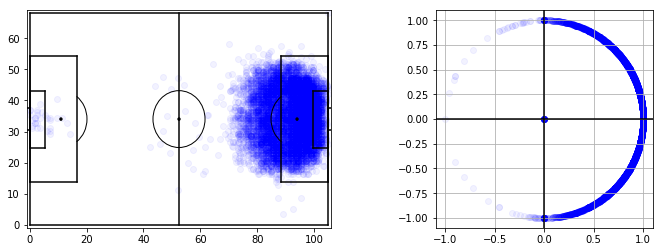

In [169]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

#a = actions[actions.type_name == "shot"][:100]


def plot_deltas(x,y,dx,dy,color):
    fig,axs = plt.subplots(1,2)
    fig.set_size_inches((12,4))
    axs[0].scatter(x,y,color=color,alpha=0.05)
    axs[1].scatter(dx,dy,color=color,alpha=0.05)
    mps.field(ax=axs[0],show=False)
    plt.axis("on")
    plt.axis("scaled")
    axs[1].axvline(0,color="black")
    axs[1].axhline(0,color="black")
    axs[1].grid()
    axs[0].set_xlim(-1,105+1)
    axs[0].set_ylim(-1,68+1)
    axs[1].set_xlim(-1.1,1.1)
    axs[1].set_ylim(-1.1,1.1)
    plt.show()
plot_deltas(a.x,a.y,a.dx,a.dy,color="blue")

100000
Initialization 0
  Iteration 10	 time lapse 34.46965s	 ll change 0.03467
  Iteration 20	 time lapse 26.85527s	 ll change 0.28459
  Iteration 30	 time lapse 27.64974s	 ll change 0.13532
  Iteration 40	 time lapse 25.99948s	 ll change 0.04751
  Iteration 50	 time lapse 25.52613s	 ll change 0.01751
  Iteration 60	 time lapse 26.72391s	 ll change 0.01365
  Iteration 70	 time lapse 25.58918s	 ll change 0.00365
  Iteration 80	 time lapse 25.48025s	 ll change 0.01032
  Iteration 90	 time lapse 25.84439s	 ll change 0.00293
  Iteration 100	 time lapse 25.73344s	 ll change 0.00272
Initialization converged: False	 time lapse 269.87153s	 ll -5.10229


/home/tomd/.local/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


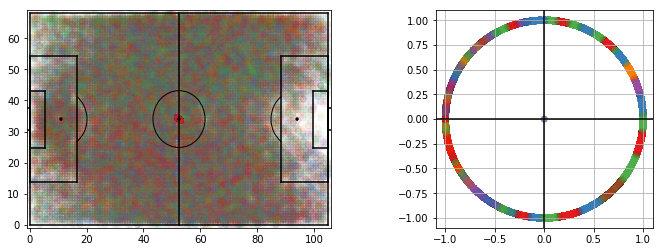

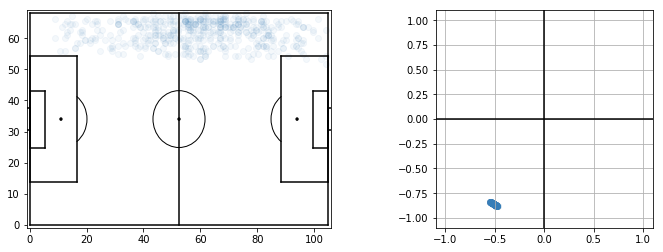

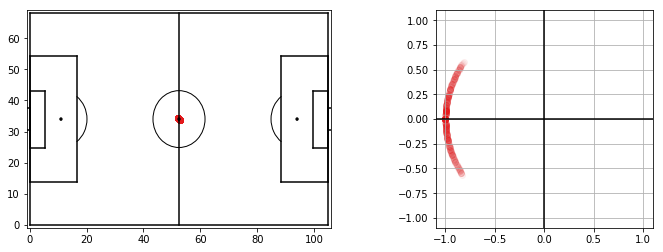

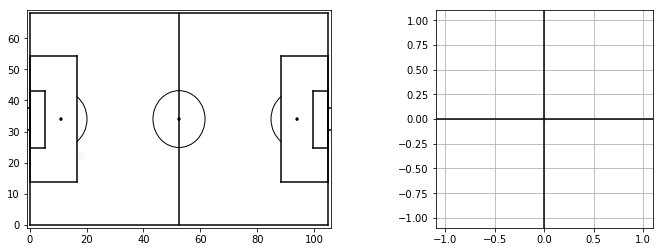

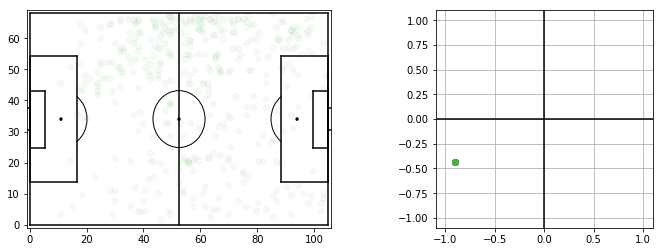

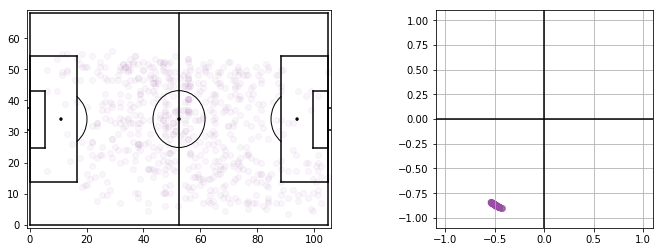

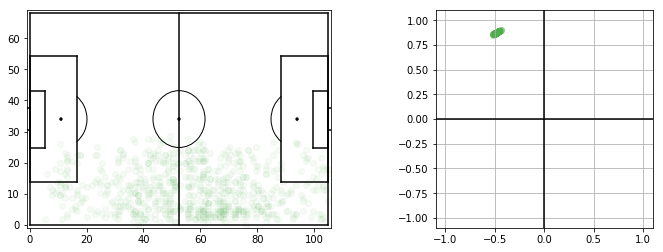

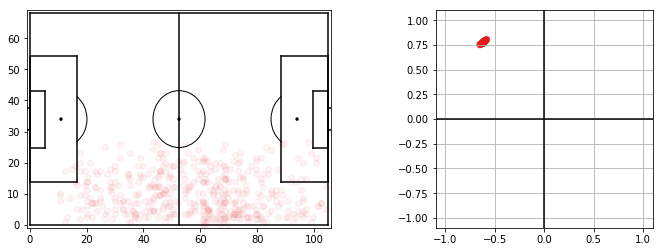

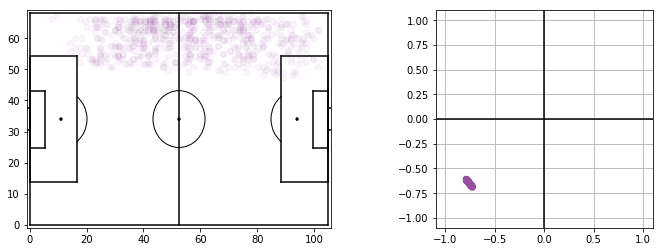

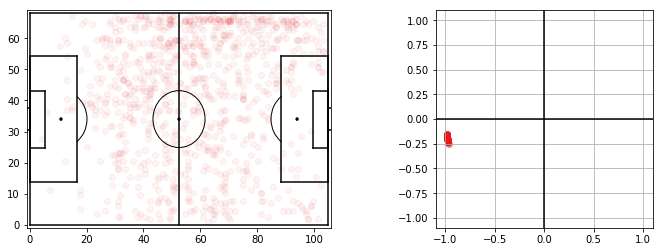

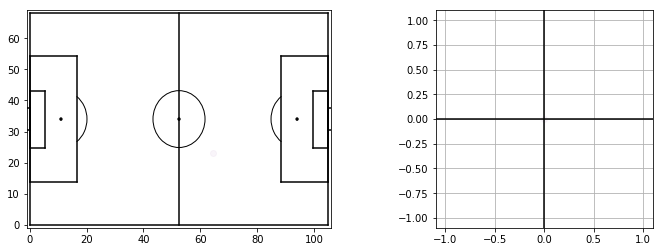

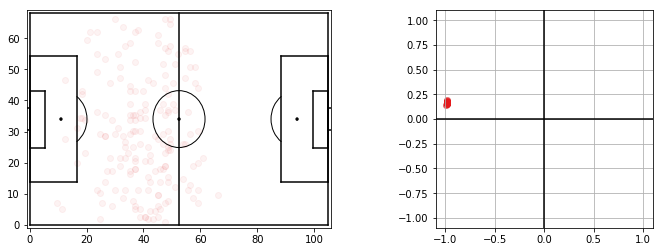

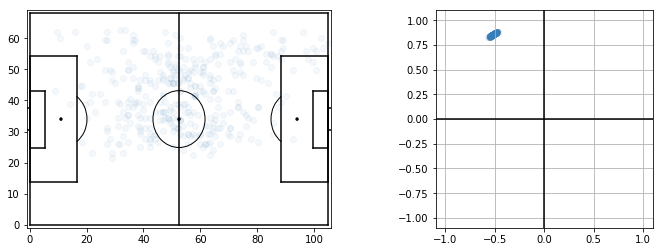

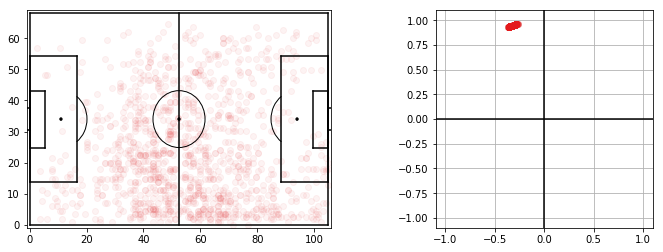

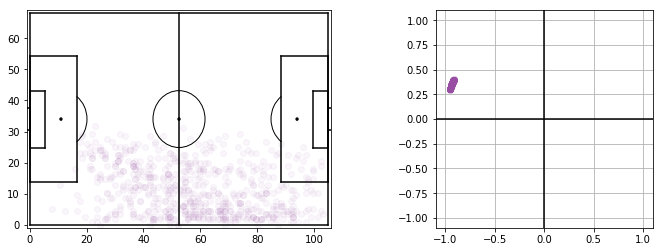

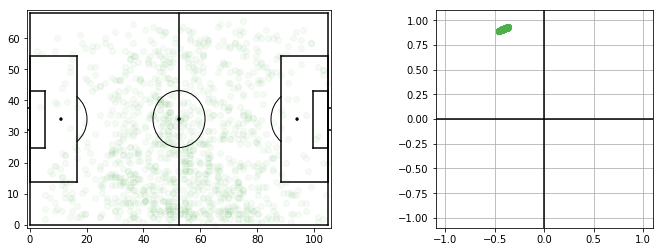

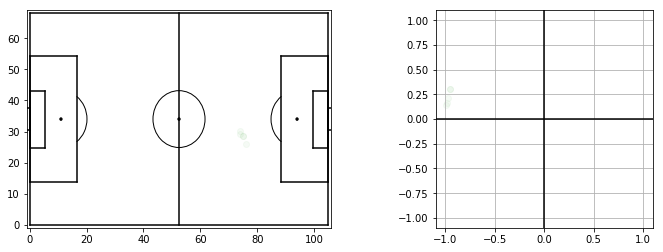

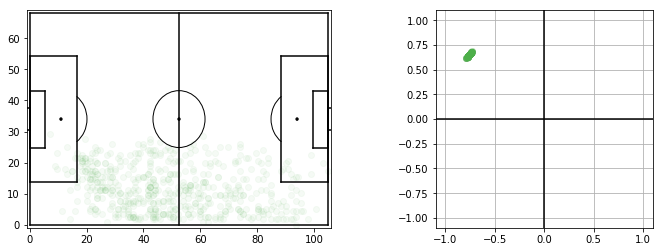

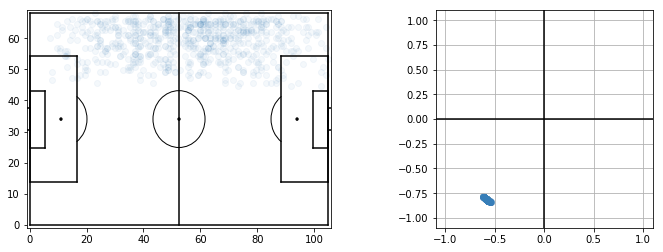

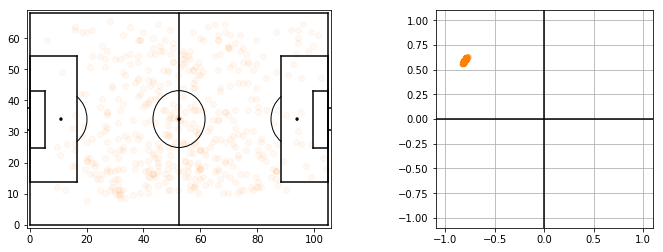

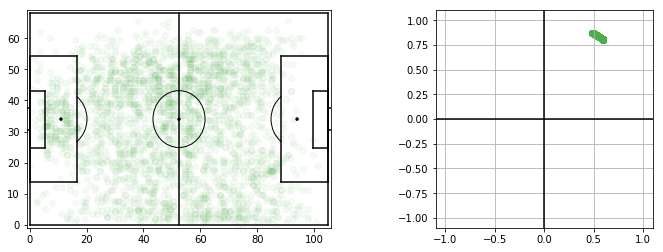

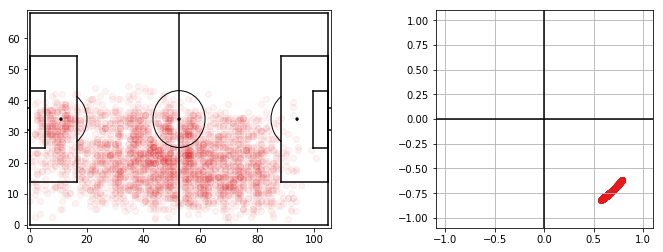

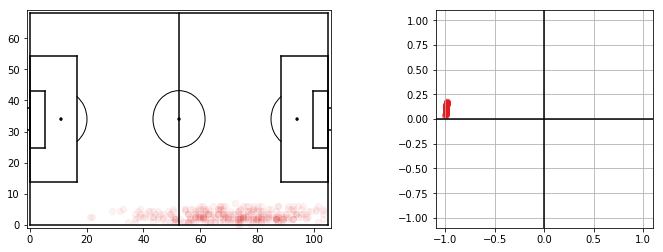

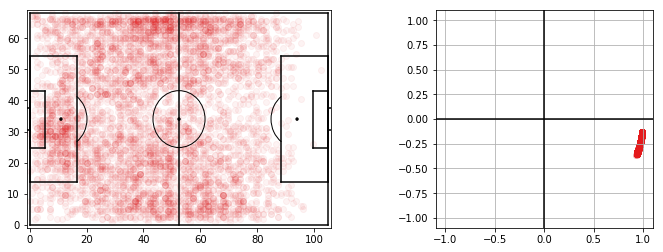

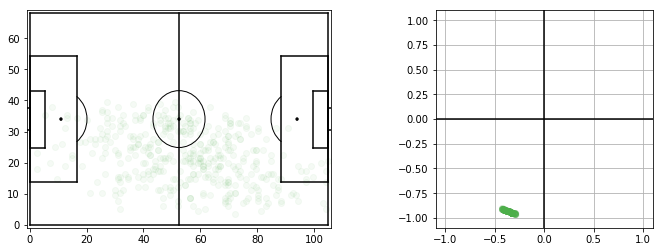

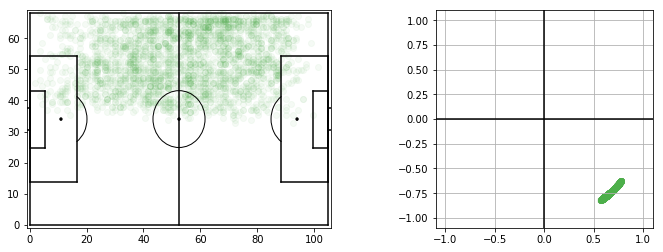

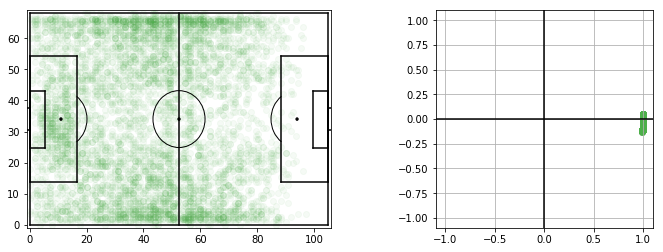

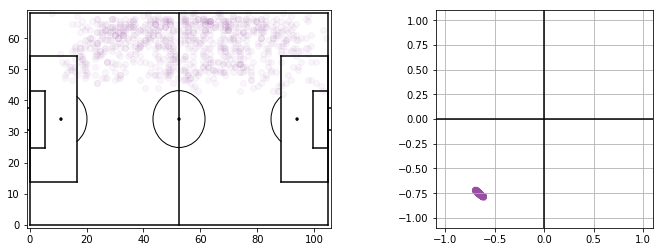

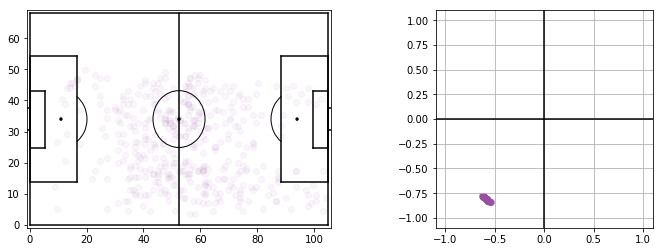

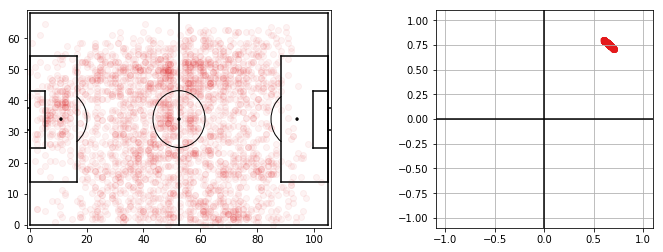

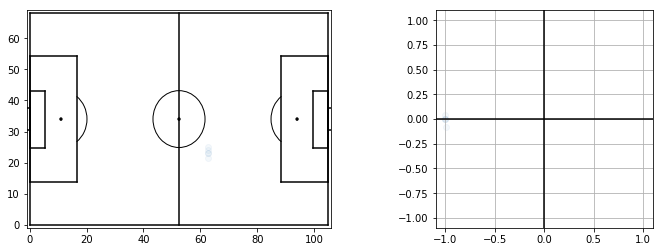

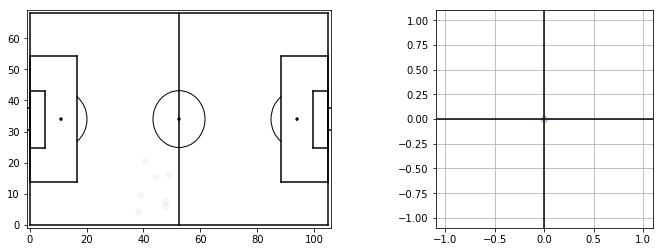

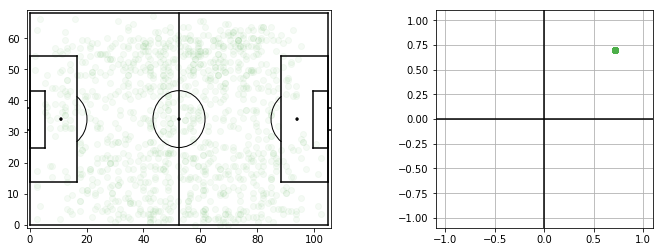

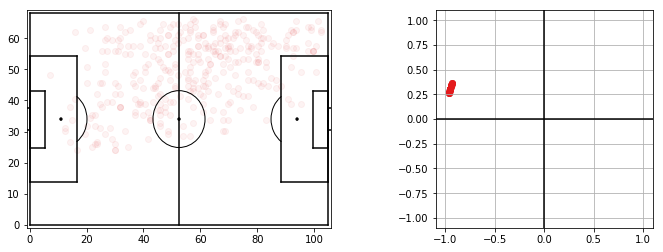

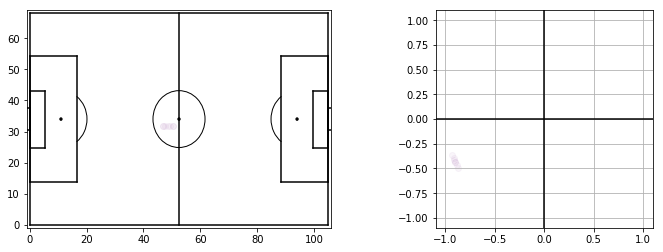

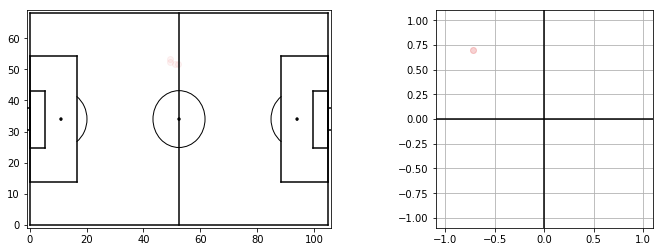

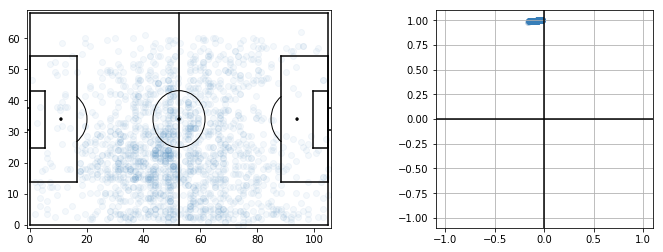

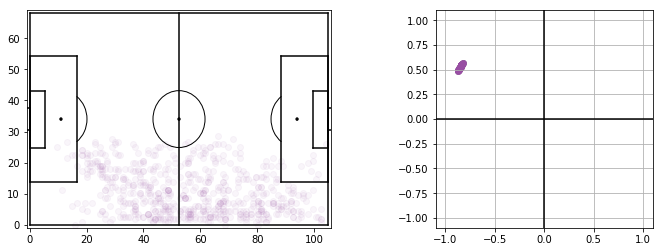

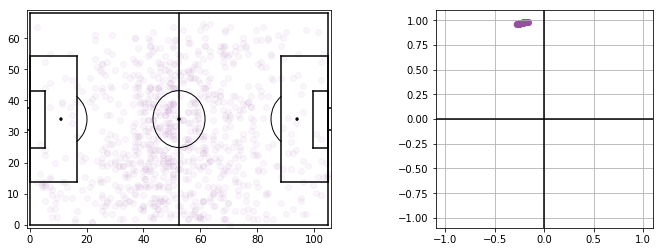

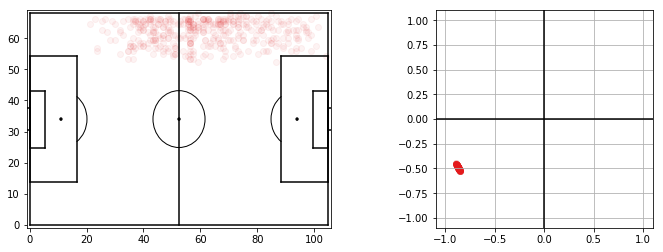

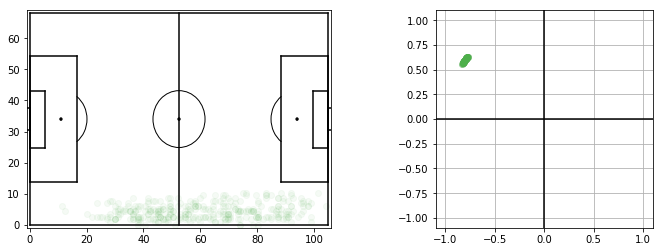

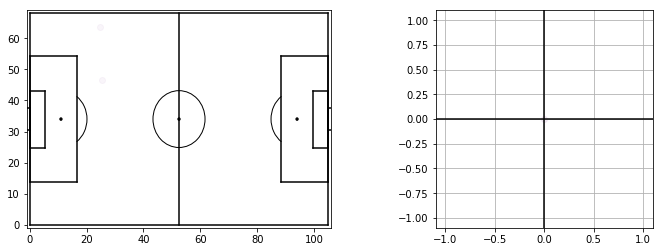

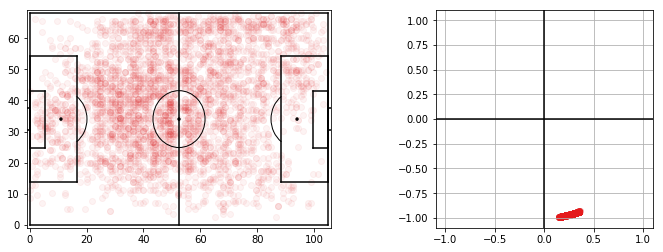

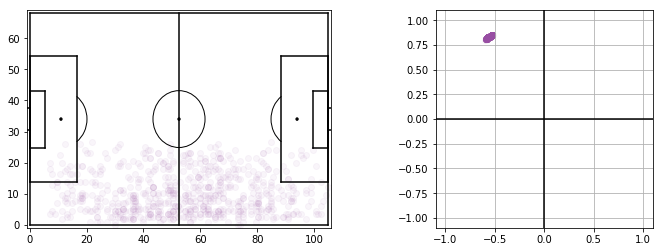

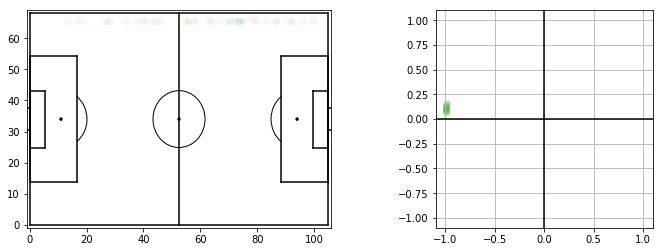

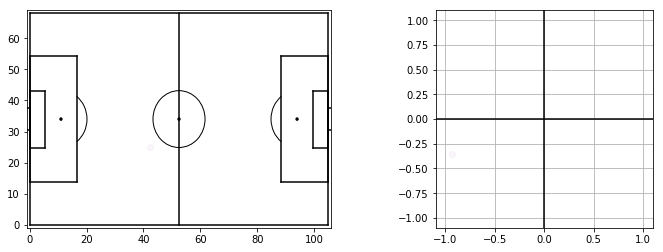

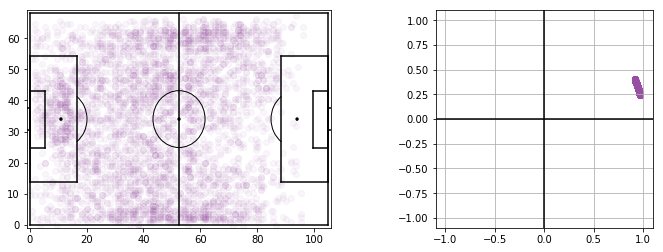

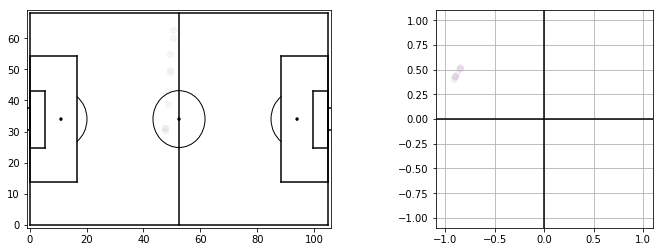

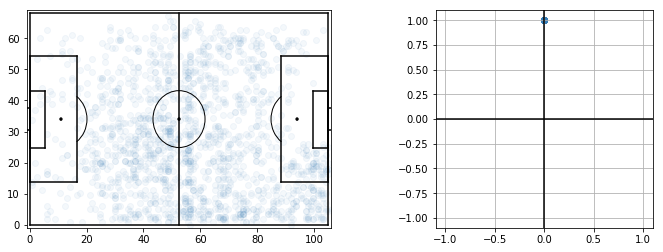

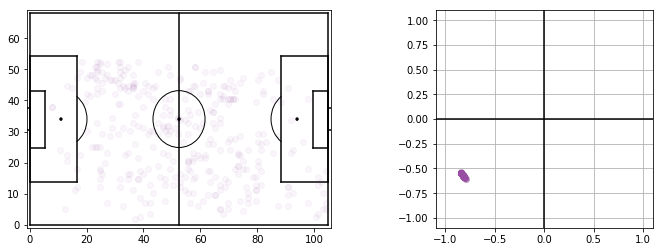

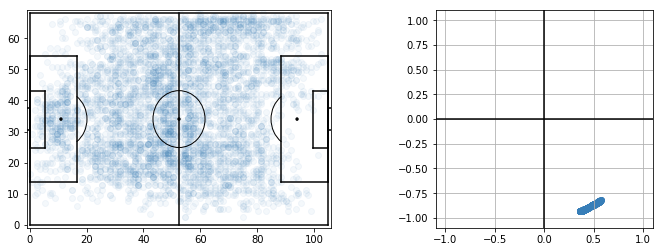

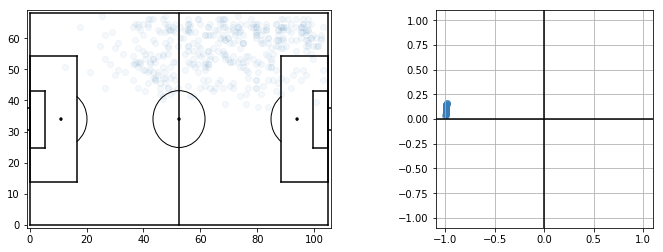

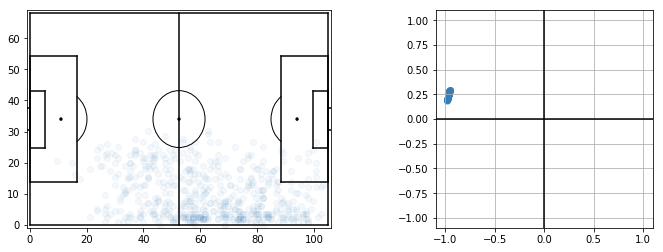

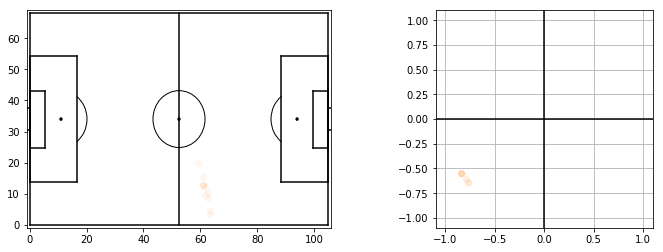

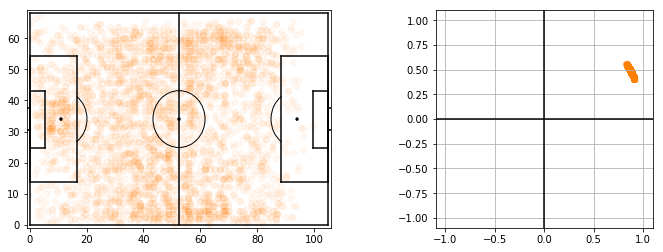

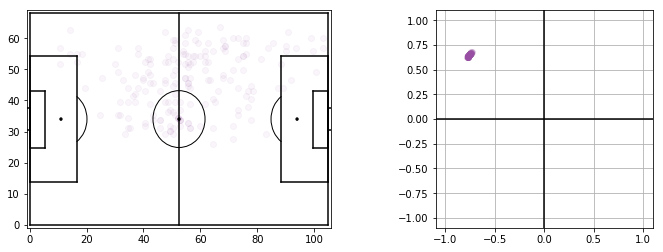

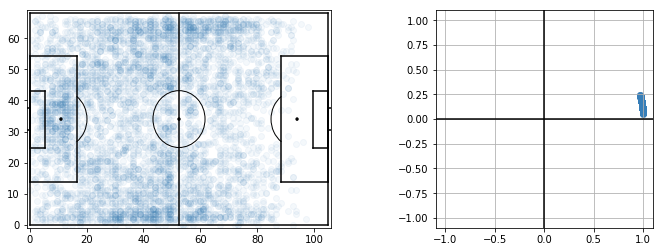

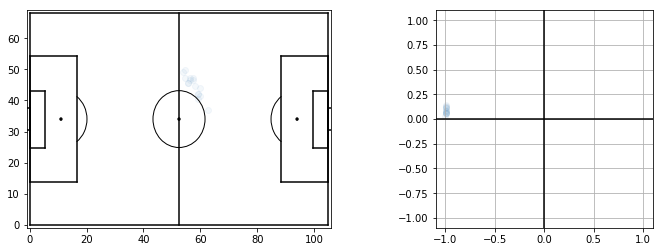

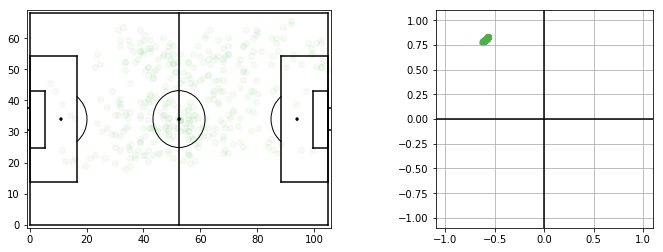

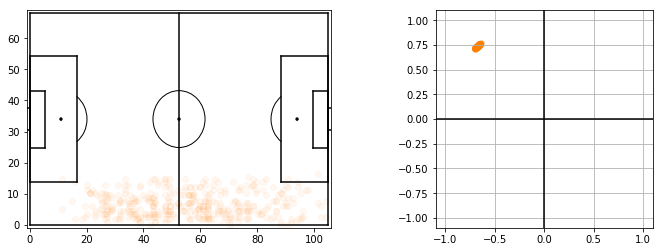

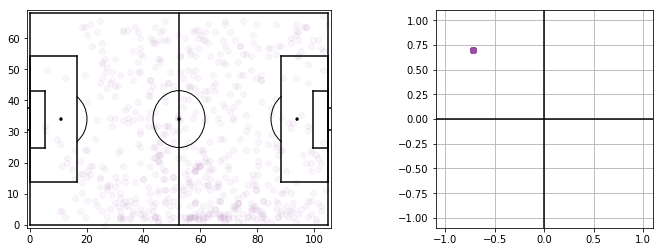

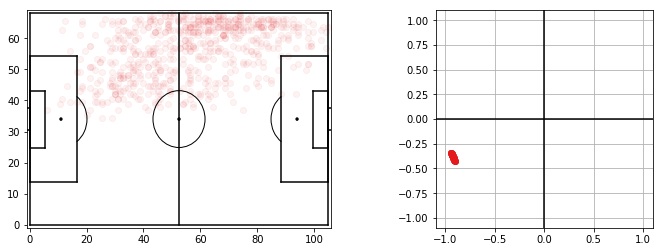

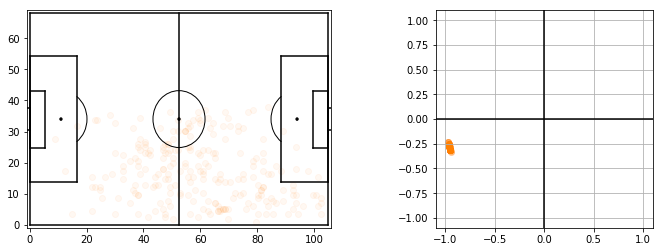

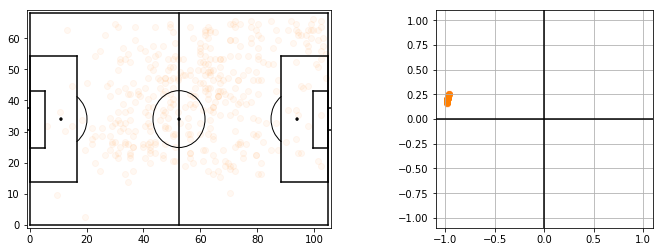

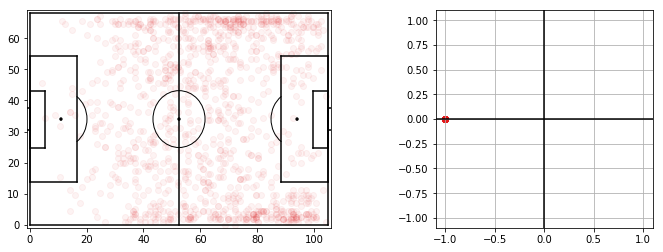

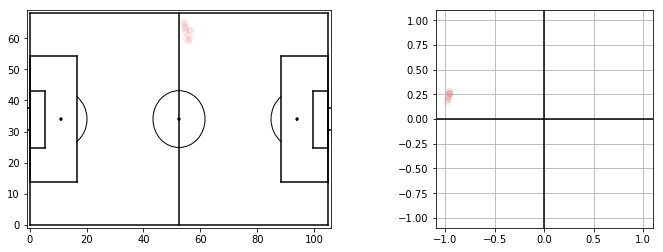

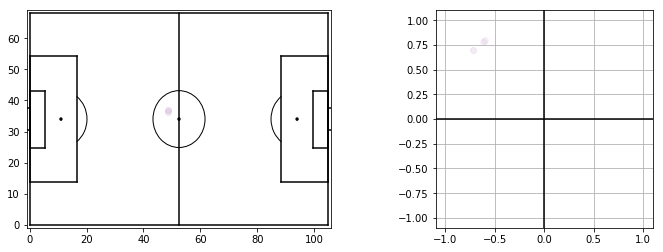

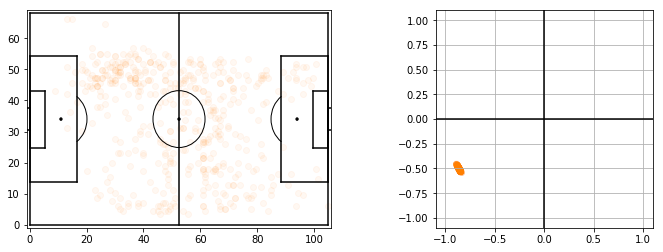

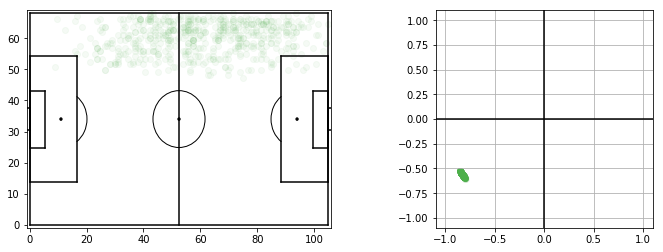

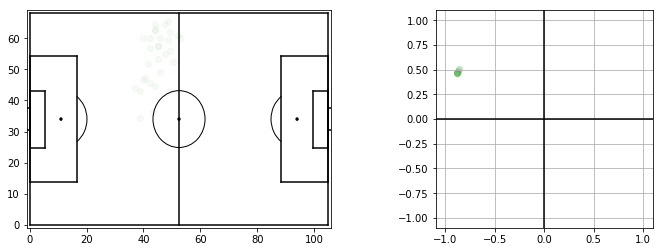

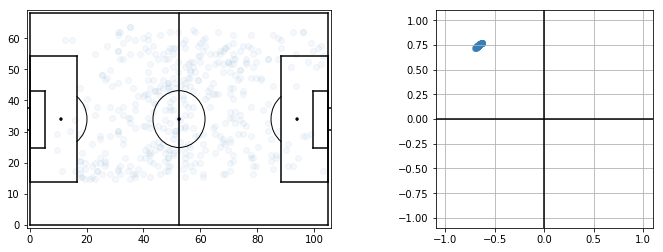

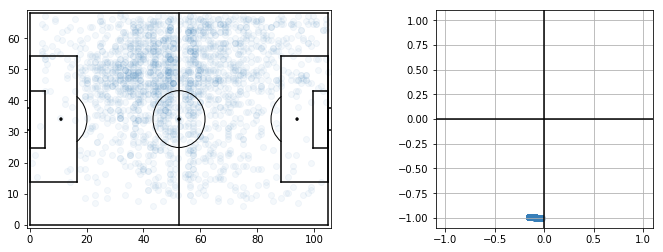

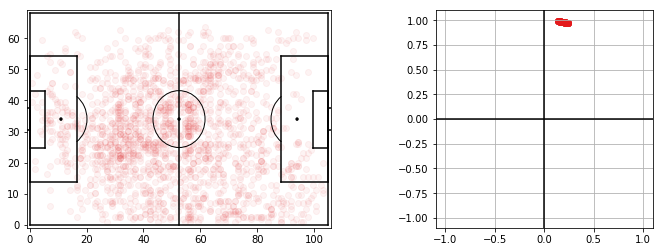

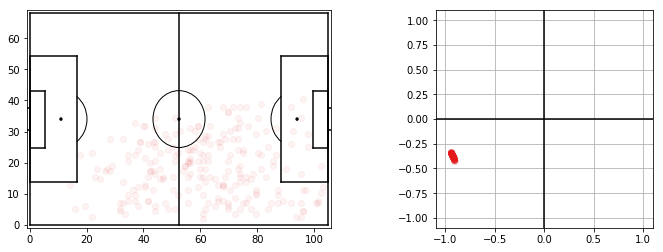

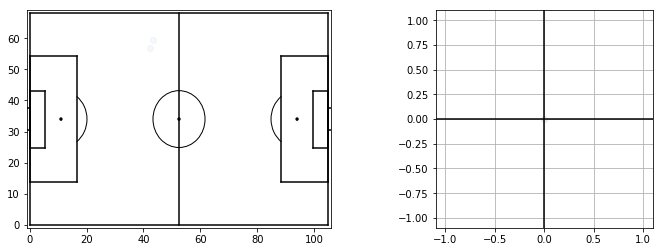

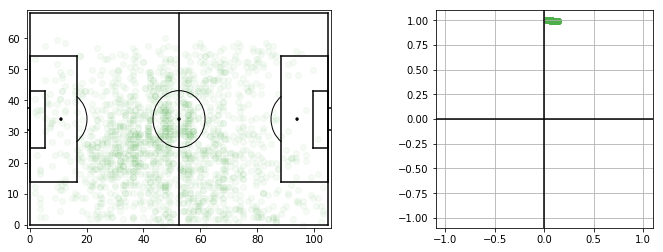

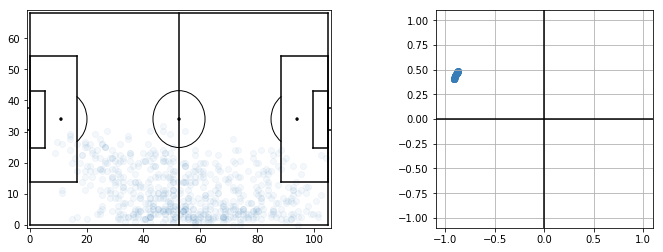

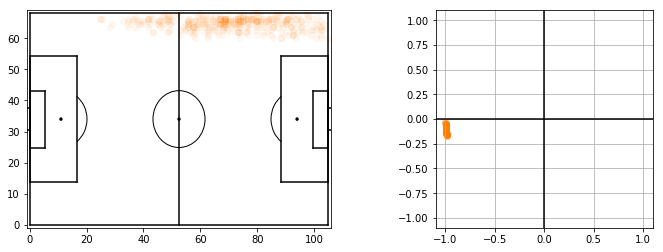

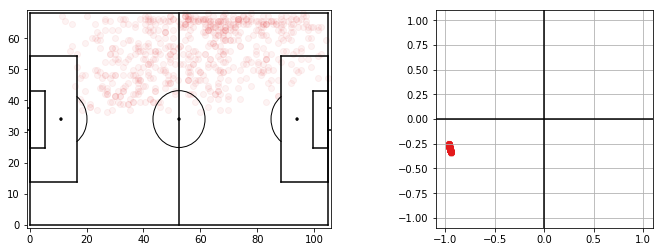

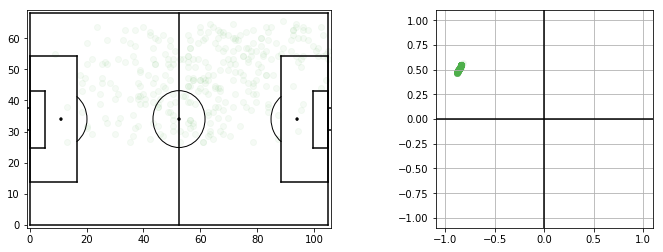

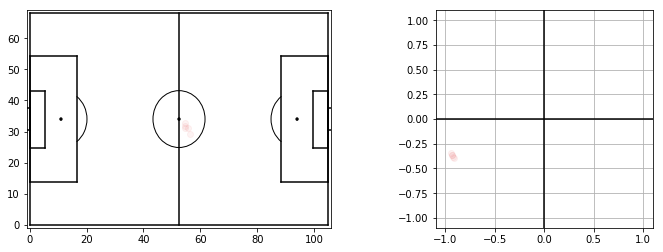

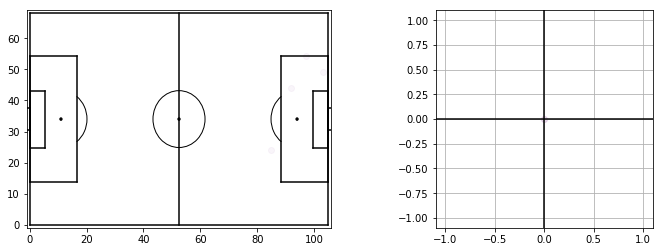

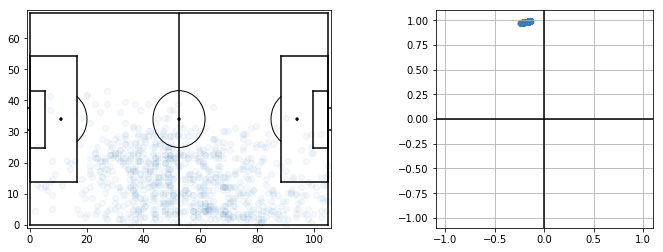

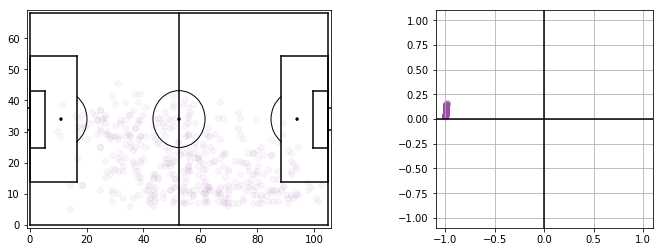

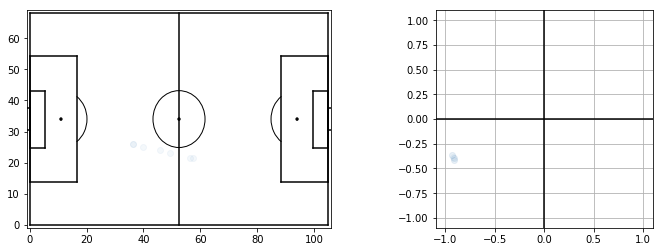

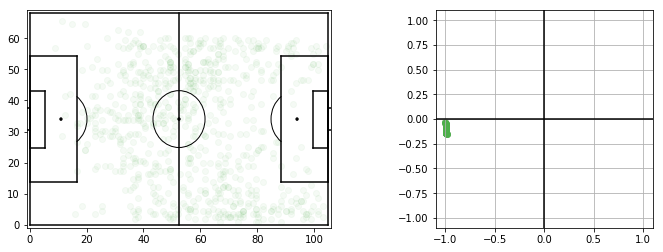

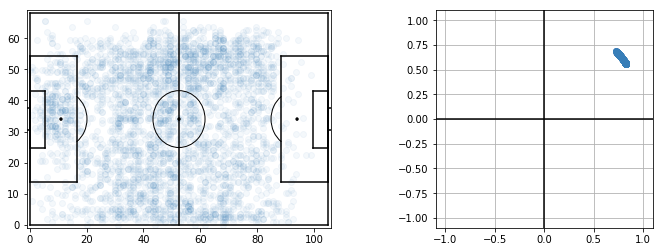

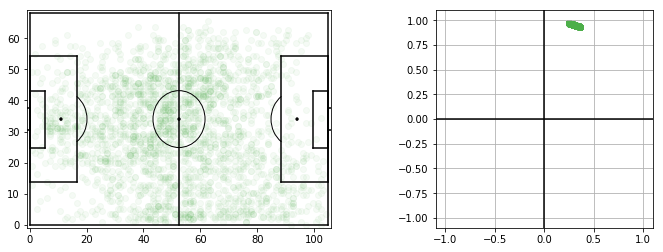

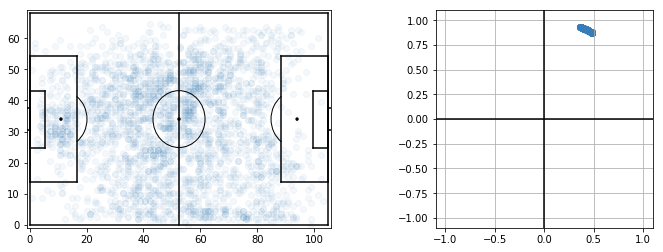

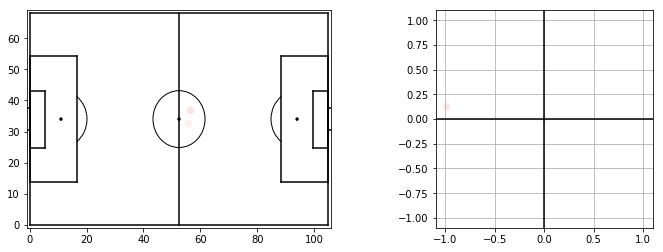

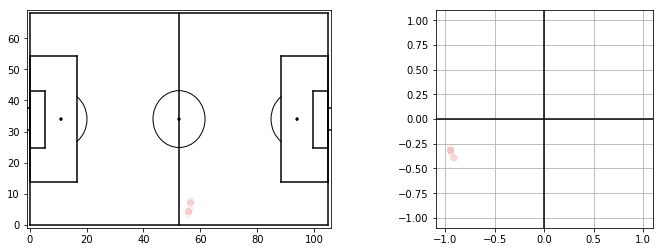

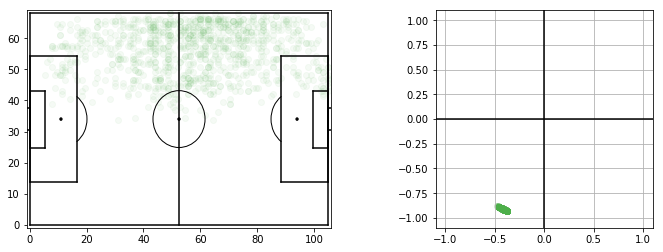

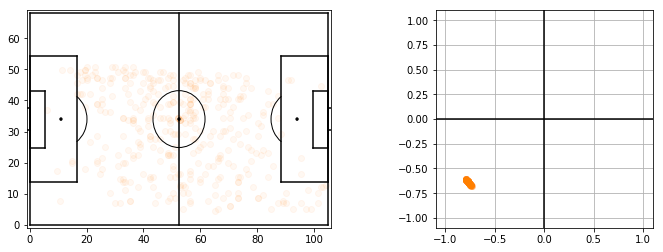

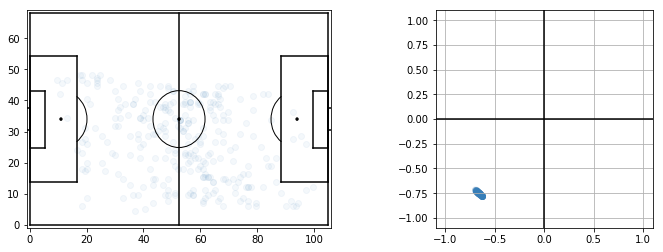

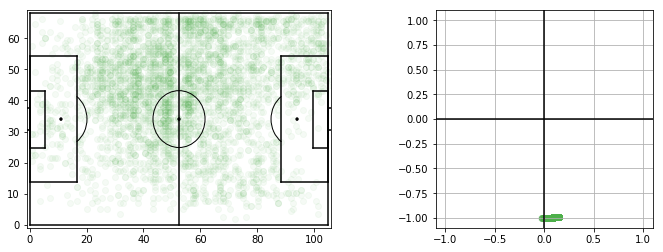

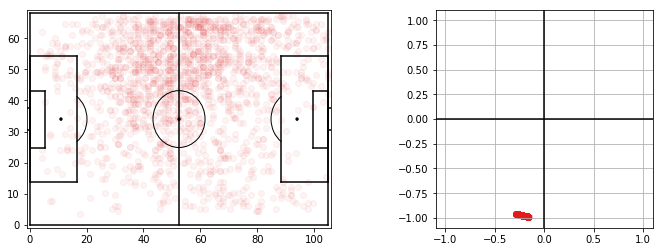

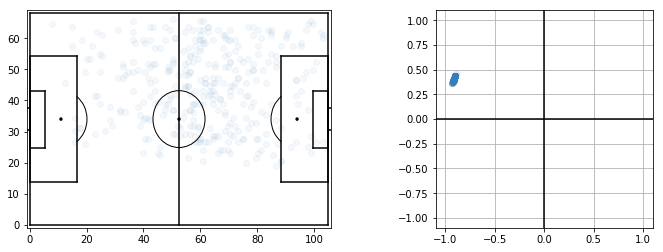

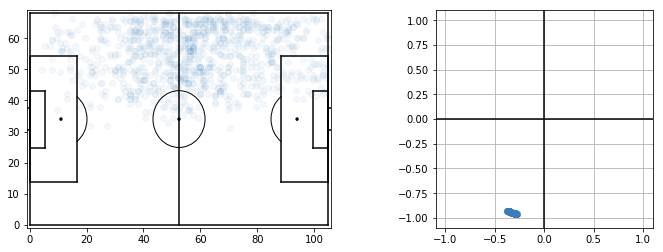

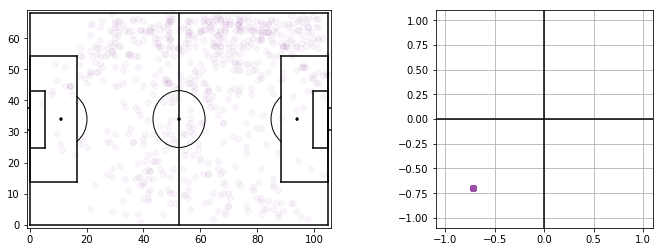

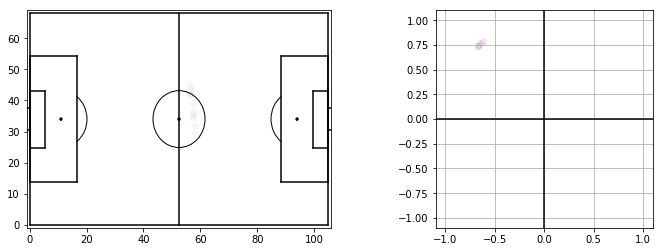

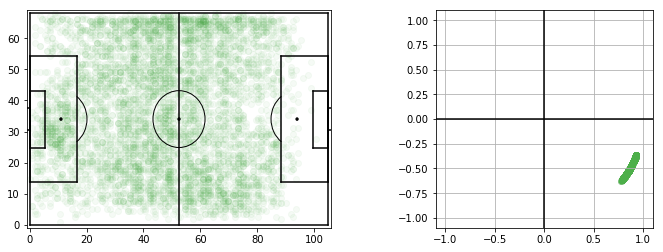

CPU times: user 10min 35s, sys: 8min 25s, total: 19min
Wall time: 5min 15s


In [226]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
import socceraction.atomic.features as fs

a = actions[actions.type_name == "pass"][:100000].copy()
print(len(a))
di = fs.direction(a)
a["dx"] = di.dx_a0
a["dy"] = di.dy_a0

nbc = 100

gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[["x","y",
                                      "dx","dy",
                                     ]])

colors = ["#e41a1c",
"#377eb8",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = color_clusters([(x,y) 
                                for (x,y,
                                     dx,dy
                                    )
                                in gmm.means_],colors)
#print(clustercolors)
labels = gmm.predict(a[["x","y",
                        "dx","dy",
                       ]])

plot_deltas(a.x,a.y,a.dx,a.dy,color=[clustercolors[l] for l in labels])
for l in set(labels):
    l_idx = labels == l
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=clustercolors[l])

Text(0.5, 0, 'n_components')

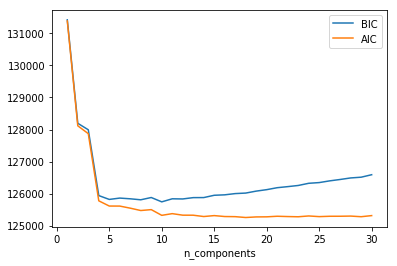

In [136]:
n_components = np.arange(1, 31)
models = [mix.GaussianMixture(n).fit(a[["x","y"]])
          for n in n_components]

plt.plot(n_components, [m.bic(a[["x","y"]]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(a[["x","y"]]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

100%|██████████| 451/451 [00:01<00:00, 256.04it/s]


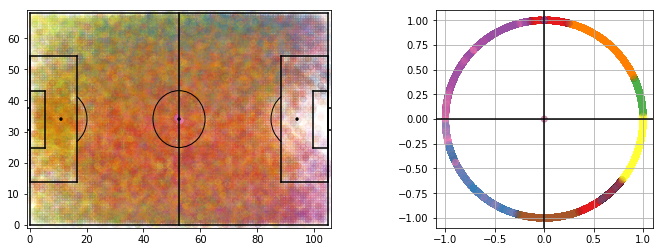

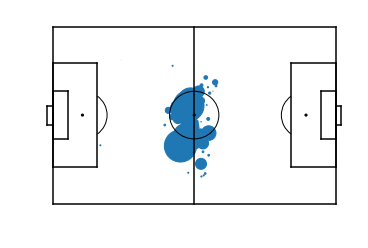

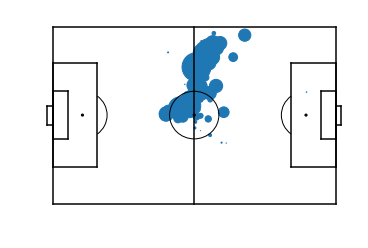

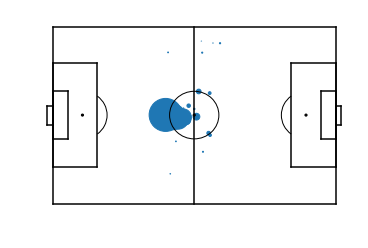

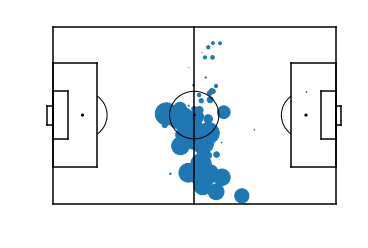

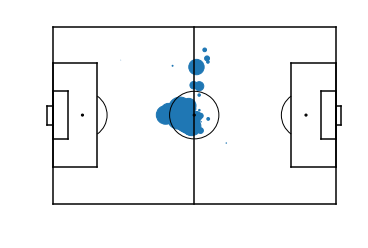

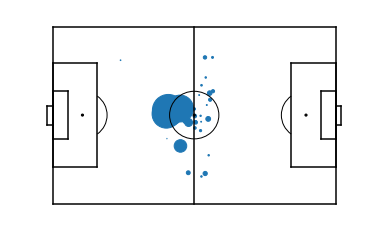

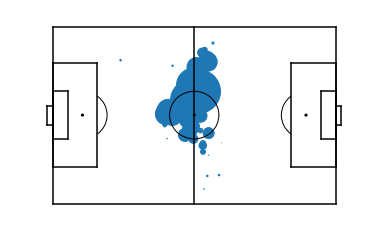

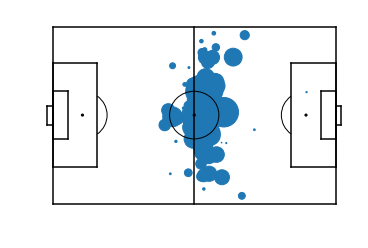

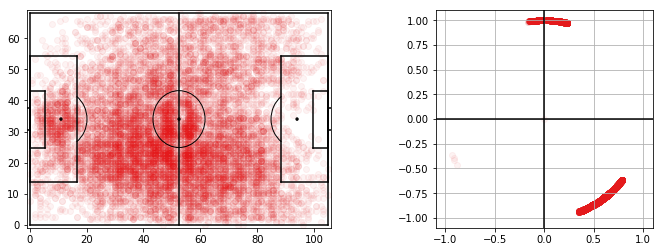

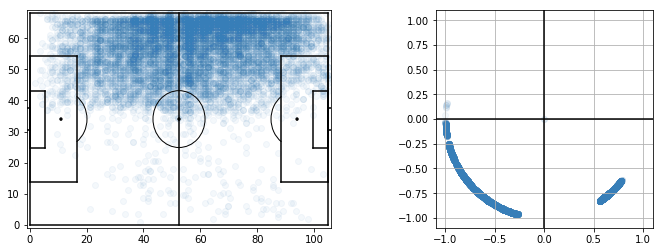

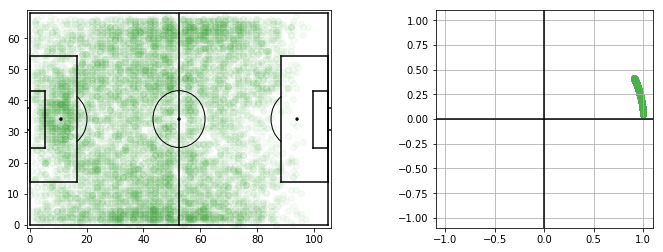

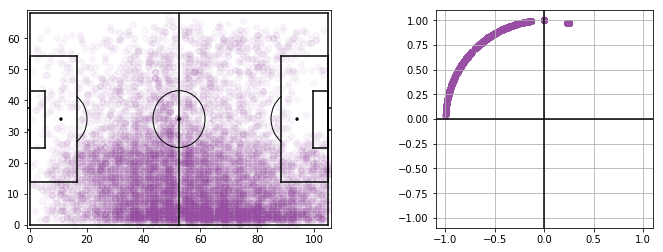

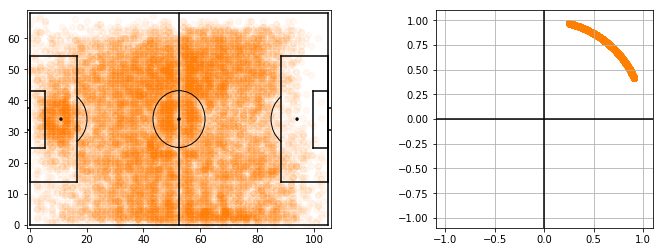

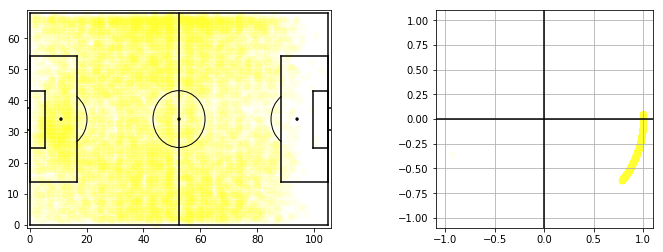

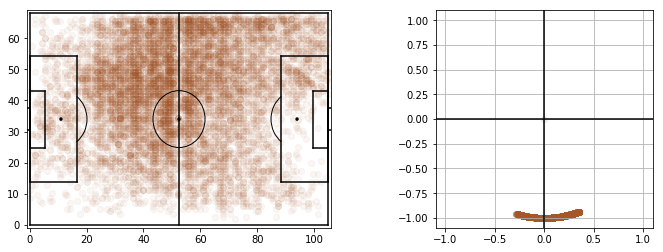

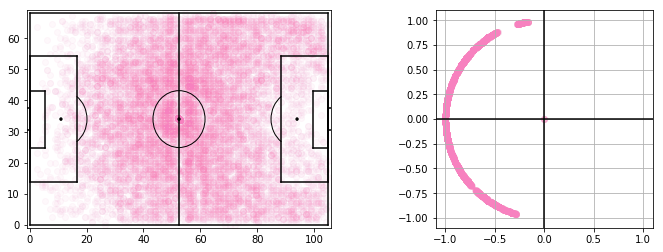

In [228]:
import numpy

nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(list(enumerate(a.groupby(["player_id"])))):
    probs = gmm.predict_proba(df[["x","y"
                                  ,"dx","dy"
                                 ]])
    playervector = probs.sum(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors


from sklearn.decomposition import NMF
model = NMF(8).fit(vectors)
model.components_

#print(model.components_ )

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

# ax = mps.field(show=False)
# for component in model.components_:
#     c_idx = component > 0.1
    
#     ax.scatter(x,y,s=100*component,alpha=0.5)
#     #plt.show()
# plt.show()    

def predict_cluster(points,gmm,nmf):
    gaussprobs = gmm.predict_proba(points)
    clusterscores = nmf.transform(gaussprobs)
    return np.argmax(clusterscores,axis=1)

points = a[["x","y",
            "dx","dy",
           ]].values
clusterlabels = predict_cluster(points,gmm,model)

#ax = mps.field(show=False)
plot_deltas(a.x,a.y,a.dx,a.dy,[list(colors*10)[l] for l in clusterlabels])
#ax.scatter(x,y,color=[colors[l] for l in clusterlabels])
#plt.show()

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    ax.scatter(x,y,s=100*component,alpha=1)
    plt.show()

for l in set(clusterlabels):
    l_idx = clusterlabels == l
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=colors[l])

In [172]:
gaussprobs = gmm.predict_proba(points)
clusterscores = model.transform(gaussprobs)

In [190]:
#plt.scatter(range(len(clusterscores[0])),clusterscores.sum(axis=1))
#plt.show()
gaussprobs.sum(axis=0)

array([ 20.06158668, 683.98134801, 387.45677871,  32.        ,
       399.52865829, 545.03124067, 205.93567172, 325.91394273,
        23.97807632, 478.84449408, 475.07318762, 501.10766955,
       514.5015272 ,   2.99996458,  15.27153978, 130.35593787,
       401.75124418,  23.64013898, 305.59273974, 595.99955081,
       303.29642009,   5.19989456, 464.38619663, 425.55798763,
        15.51186233, 466.85743203, 506.60588709, 444.10530811,
       247.05541684, 251.39829718])